In [1]:
!pip install pydriller==1.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.0 MB/s eta 0:00:00


In [2]:
from pydriller import RepositoryMining
import pandas as pd
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
file_stats = defaultdict(lambda: {
    'count': 0,
    'insertions': 0,
    'deletions': 0,
    'last_date': None,
    'authors': set()
})


for commit in RepositoryMining('https://github.com/numpy/numpy').traverse_commits():
    author = commit.author.name
    date = commit.committer_date

    for file in commit.modifications:
        if file.filename is None:
            continue
        path = file.new_path or file.old_path or file.filename

        file_stats[path]['count'] += 1
        file_stats[path]['insertions'] += file.added
        file_stats[path]['deletions'] += file.removed
        file_stats[path]['authors'].add(author)

        if file_stats[path]['last_date'] is None or date > file_stats[path]['last_date']:
            file_stats[path]['last_date'] = date


df = pd.DataFrame([
    {
        'file': k,
        'change_count': v['count'],
        'insertions': v['insertions'],
        'deletions': v['deletions'],
        'file_extension': os.path.splitext(k)[1],
        'last_modified': int(v['last_date'].timestamp()) if v['last_date'] else None,
        'authors': ", ".join(sorted(v['authors']))
    }
    for k, v in file_stats.items()
])

,file,change_count,insertions,deletions,file_extension,last_modified,authors
0,scipy_distutils/__init__.py,7,38,28,.py,1101031726,"Eric Jones, Pearu Peterson"
1,scipy_distutils/command/__init__.py,4,33,3,.py,1084798190,"Eric Jones, Pearu Peterson"
2,scipy_distutils/command/build.py,7,88,10,.py,1075673273,"Eric Jones, Pearu Peterson"
3,scipy_distutils/command/build_clib.py,19,498,274,.py,1096367461,"Eric Jones, Pearu Peterson, jswhit"
4,scipy_distutils/command/build_ext.py,56,1152,775,.py,1111656163,"Eric Jones, Pearu Peterson, Travis Oliphant, d..."


In [7]:
df['authors_count'] = df['authors'].apply(lambda x: len(x))
df['file_age'] = (pd.to_datetime('now') - pd.to_datetime(df['last_modified'], unit='s')).dt.days
df.to_csv("file_change_stats_with_authors_and_date.csv", index=False)
df.head()

,file,change_count,insertions,deletions,file_extension,last_modified,authors,authors_count,file_age
0,scipy_distutils/__init__.py,7,38,28,.py,1101031726,"Eric Jones, Pearu Peterson",26,7493
1,scipy_distutils/command/__init__.py,4,33,3,.py,1084798190,"Eric Jones, Pearu Peterson",26,7681
2,scipy_distutils/command/build.py,7,88,10,.py,1075673273,"Eric Jones, Pearu Peterson",26,7787
3,scipy_distutils/command/build_clib.py,19,498,274,.py,1096367461,"Eric Jones, Pearu Peterson, jswhit",34,7547
4,scipy_distutils/command/build_ext.py,56,1152,775,.py,1111656163,"Eric Jones, Pearu Peterson, Travis Oliphant, d...",53,7370


<ipython-input-8-9c6c6ce6467c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='change_count', y='file', data=top_files, palette="Blues_d")


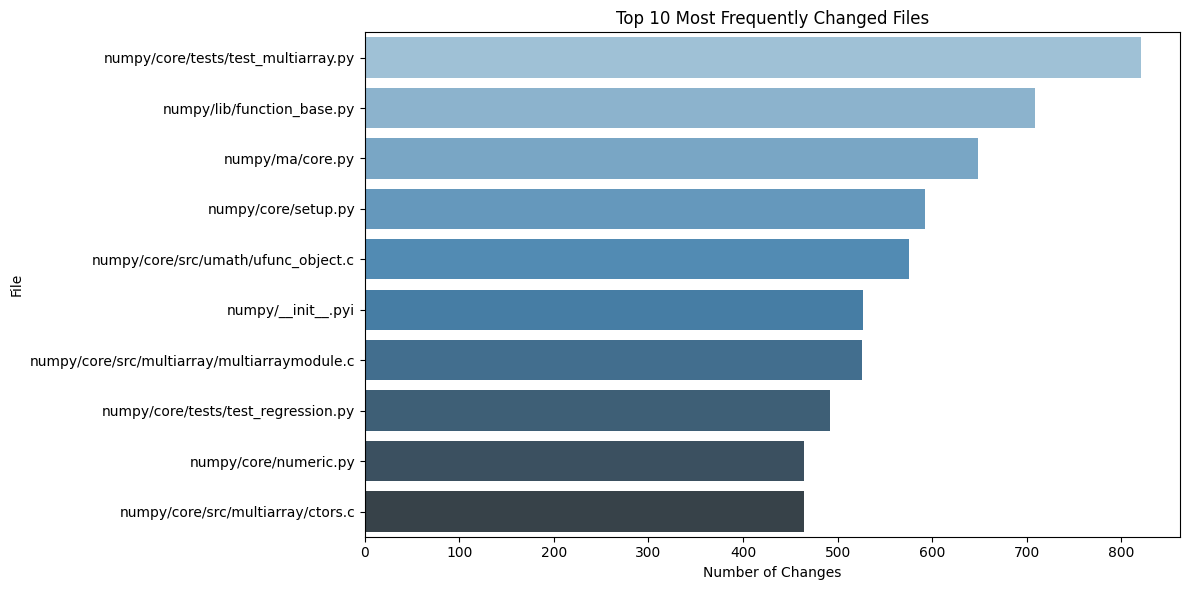

In [8]:
top_files = df.sort_values('change_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='change_count', y='file', data=top_files, palette="Blues_d")
plt.title('Top 10 Most Frequently Changed Files')
plt.xlabel('Number of Changes')
plt.ylabel('File')
plt.tight_layout()
plt.savefig('top_changed_files.png')


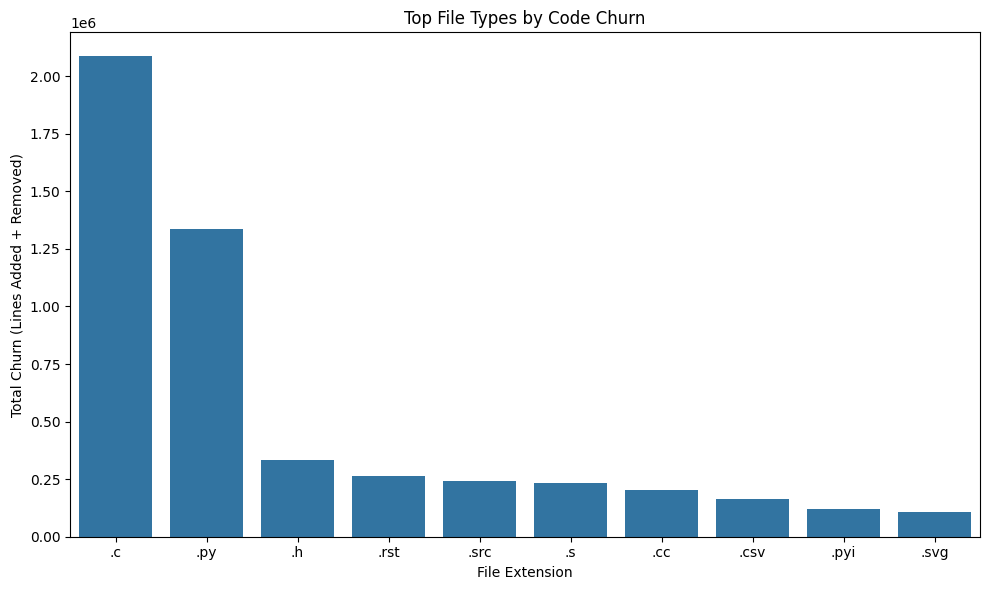

In [9]:
ext_churn = df.groupby('file_extension')[['insertions', 'deletions']].sum()
ext_churn['churn'] = ext_churn['insertions'] + ext_churn['deletions']
ext_churn = ext_churn.sort_values('churn', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=ext_churn.index, y=ext_churn['churn'])
plt.title('Top File Types by Code Churn')
plt.xlabel('File Extension')
plt.ylabel('Total Churn (Lines Added + Removed)')
plt.tight_layout()
plt.savefig('file_type_churn.png')
